In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

### Espectograma

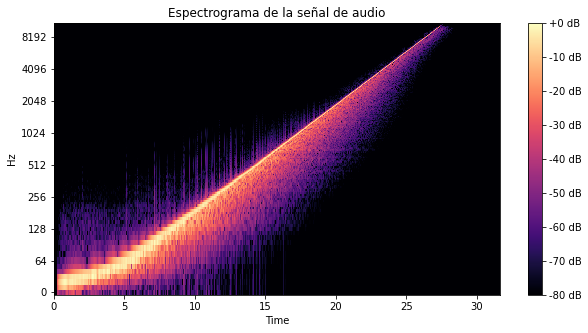

In [3]:
audio_path = './frecuencias/Audio_Sweep_r.wav'
y, sr = librosa.load(audio_path)

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.figure(figsize=(10, 5))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma de la señal de audio')
plt.show()

### Codigo Prinicipal

In [24]:
def find_rt60(audio_path, plot=True, values=True,name_df='col'):
        
    y, sr = librosa.load(audio_path)
    
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    target_frequencies = [250, 500, 1000, 2000, 4000, 8000, 16000] 
    colors_frequencies = ["b", "g", 'orange', "c", "m", "y", "r"]
    
    frequency_indices = [np.argmin(np.abs(librosa.fft_frequencies(sr=sr) - f)) for f in target_frequencies]
    
    time = librosa.times_like(D, sr=sr)
    
    amplitudes_dB = []
    for index in frequency_indices:
        amplitude_dB = D[index]
        amplitudes_dB.append(amplitude_dB)
    
    amplitude_250Hz, amplitude_500Hz, amplitude_1000Hz, amplitude_2000Hz, amplitude_4000Hz, amplitude_8000Hz, amplitude_16000Hz = amplitudes_dB
    if plot:
        plt.figure(figsize=(10, 5))
        for index, freq, color in zip(frequency_indices, target_frequencies, colors_frequencies):
            amplitude_dB = D[index]
            plt.plot(time, amplitude_dB, label=f'{freq} Hz', color=color)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (dB)')
        plt.title('Amplitude in dB of Frequencies over Time')
        plt.legend()
        plt.show()
    
    index = 0
    rt_values = []
    
    for i in amplitudes_dB:
        if i.mean() != -80:
            targets = None
            # colors=None

            size = np.argmax(i)
            max(i)
            rt60 = max(i) - 60

            def find_nearest_value_position(array, value):
                lesser_index = None

                for j, number in enumerate(array):
                    if number < value and lesser_index is None:
                        lesser_index = j

                greater_index = lesser_index - 1

                return lesser_index

            def find_consecutive_values(lst, desired_value):
                consecutives = 0

                for j, val in enumerate(lst):
                    if val == desired_value:
                        consecutives += 1
                    else:
                        consecutives = 0  

                    if consecutives == 10:
                        return j - 7 

                return None  

            final_value = int(find_consecutive_values(i[size:], -80)) + size

            numbers = i[np.argmax(i):] 

            desired_number = max(i) - 60

            position = find_nearest_value_position(numbers, desired_number)

            timeRT = round(time[position], 4)

            rt60 = timeRT

            final_time = find_consecutive_values(i[size:], -80)

            position_rt_time = position
            position_rt_amplitude = i[size + position]
            initial_time = i[size:size + find_consecutive_values(i[size:], -80)]
            
            if plot:
                plt.plot(time[:final_time], initial_time, color=colors_frequencies[index], zorder=1)
                plt.scatter(time[position_rt_time], position_rt_amplitude, color='k', zorder=4, label=f'RT60 ({timeRT} [s], {round(desired_number, 2)} [dB])')
                plt.title(f'RT of {target_frequencies[index]}Hz is {timeRT} s')
                plt.axhline(y=position_rt_amplitude, color='k', linestyle='--')
                plt.xlabel('Time [s]')
                plt.ylabel('Amplitude [dB]')
    
                plt.legend()
                plt.show()

            index = index + 1    
            rt_values.append(rt60)
        else: 
            rt_values.append(None)
    if values:    
        nombre_archivo = 'mi_dataframe.csv'
        
        if os.path.exists(nombre_archivo):
            df_existente = pd.read_csv(nombre_archivo)
            nombre_nueva_columna = name_df

            df_existente[nombre_nueva_columna] = rt_values

            df_existente.to_csv(nombre_archivo, index=False)
        else:
            df_final = pd.DataFrame(rt_values, columns=[name_df])


            df_final.to_csv(nombre_archivo, index=False)
            print(f"Se ha guardado el DataFrame en {nombre_archivo}")


        return rt_values


### Creador de Graficos

In [33]:
find_rt60('./frecuencias/Audio_Sweep_r.wav',False,True)

[3.8777, 3.4133, 3.3205, 1.3003, 1.3468, 0.8359, None]

### Creador de CSV

In [28]:
import os

directorio = './frecuencias/'

archivos = sorted(os.listdir(directorio))
for archivo in archivos:
    ruta_completa = os.path.join(directorio, archivo)
    
    if os.path.isfile(ruta_completa):
    # print(archivo)
        find_rt60(f'{directorio}{archivo}',False,True,f'{os.path.splitext(archivo)[0]}')[2]



Se ha guardado el DataFrame en mi_dataframe.csv
